In [9]:
# imports
import numpy as np
import pandas as pd
import glob
import mediapipe as mp # for hand detection
import cv2 # for capturing videos
import pickle # to save the model
import argparse
import os
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as pl
from PIL import Image
from tqdm import tqdm

In [10]:
# initialize mediapipe
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

In [11]:
# CONSTANTS
# Path to the data folder : 300x300 images, padding, no cropping
frames_300x300_AfP = glob.glob("../data/different_input_size_60fps/300_300_AfP/*.png")

# Path to the data folder : 300x300 images, no padding, cropping
frames_300x300_AfC = glob.glob("../data/different_input_size_60fps/300_300_AfC/*.png")

In [12]:
# load all video frames into numpy array
all_frames = np.array([np.array(Image.open(fname)) for fname in tqdm (frames_300x300_AfP)])
print(all_frames.shape)
print(type(all_frames))

100%|██████████| 28854/28854 [02:17<00:00, 209.76it/s]


(28854, 300, 300, 3)
<class 'numpy.ndarray'>


In [13]:
# drop last 28 frames from all_frames to match ground_truth shape
all_frames = all_frames[:-28]
print(all_frames.shape)

(28826, 300, 300, 3)


In [14]:
# compute the center of the hand based on the detected landmarks
def compute_hand_center(landmarks, selected_ids, image_width, image_height):
    x = 0.0
    y = 0.0
    for i in selected_ids:
        x += landmarks.landmark[i].x
        y += landmarks.landmark[i].y
    x /= len(selected_ids)
    y /= len(selected_ids)
    return x*image_width, y*image_height

In [15]:
# select just 100 of the 28'826 frames to test the algorithm
test_frames = all_frames[0:100]
print(test_frames.shape)

(200, 300, 300, 3)


In [16]:
# initialize variables
# hands is a list of lists, each list contains the coordinates of the center of the hand in each frame and the frame index
hands = []

with mp_hands.Hands(static_image_mode=True,
                    max_num_hands=2,
                    min_detection_confidence=0.5) as hand:

#--------------- iterate through the frames ------------------------------------
    for frame_index in tqdm(range(all_frames.shape[0])):
        image = all_frames[frame_index,:,:,:]
        image_width = image.shape[1]
        image_height = image.shape[0]

#--------------- perform hand detection and tracking ---------------------------
        results_hand = hand.process(image)

        # create variables to store the coordinates of the center of both hands
        first_hand = None
        second_hand = None

        if results_hand.multi_hand_landmarks:
            landmarks1 = results_hand.multi_hand_landmarks[0] # first hand detected
            hand_x1, hand_y1 = compute_hand_center(landmarks1, [0, 5, 9, 13, 17], image_width, image_height)
            first_hand= [hand_x1, hand_y1]
            if len(results_hand.multi_hand_landmarks) > 1:
                landmarks2 = results_hand.multi_hand_landmarks[1] # second hand detected
                hand_x2, hand_y2 = compute_hand_center(landmarks2, [0, 5, 9, 13, 17], image_width, image_height)
                second_hand = [hand_x2, hand_y2]

        hands.append([frame_index, first_hand,second_hand])

100%|██████████| 28826/28826 [35:44<00:00, 13.44it/s]


In [17]:
print(hands[3])

[3, [168.38631391525269, 161.72376036643982], [217.94182062149048, 175.3351378440857]]


In [18]:
# save the hands coordinates to a pickle file in the pickle_files folder
file_name = os.path.join(".", "pickle_data", "300_300_AfP_hands_coordinates.pickle")
with open(file_name, "wb") as f:
    pickle.dump(hands, f)

In [19]:
# load the hands coordinates from the pickle file
file_name = os.path.join(".", "pickle_data", "300_300_AfP_hands_coordinates.pickle")
with open(file_name, "rb") as f:
    hands = pickle.load(f)

# display the hands coordinates
hands


[[0, None, None],
 [1, None, None],
 [2, None, None],
 [3,
  [168.38631391525269, 161.72376036643982],
  [217.94182062149048, 175.3351378440857]],
 [4, [242.26854801177979, 193.36541175842285], None],
 [5, None, None],
 [6, [172.61563897132874, 160.69239377975464], None],
 [7, [265.8622133731842, 165.8008074760437], None],
 [8, None, None],
 [9, None, None],
 [10, [186.74133896827698, 139.62426602840424], None],
 [11, None, None],
 [12, None, None],
 [13,
  [173.96552681922913, 163.42387676239014],
  [210.11804580688477, 171.09554171562195]],
 [14, None, None],
 [15,
  [171.34285926818848, 159.7652506828308],
  [208.17617297172546, 172.0902407169342]],
 [16, None, None],
 [17, None, None],
 [18, None, None],
 [19, [159.86778616905212, 162.7082920074463], None],
 [20, None, None],
 [21, None, None],
 [22, None, None],
 [23, None, None],
 [24, None, None],
 [25,
  [194.25456762313843, 186.99950337409973],
  [163.57656598091125, 188.49355101585388]],
 [26, [194.73654985427856, 145.7788932

In [20]:
frames_with_hands = 0
frames_with_both_hands = 0

for hand in hands:
    if hand[1] != None or hand[2] != None:
        frames_with_hands += 1
    if hand[1] != None and hand[2] != None:
        frames_with_both_hands += 1

print("Percentage of frames with at least one hand detected : ", frames_with_hands/len(hands)*100, "%")
print("Percentage of frames with both hands detected : ", frames_with_both_hands/len(hands)*100, "%")

Percentage of frames with at least one hand detected :  42.562270172760705 %
Percentage of frames with both hands detected :  8.707416915284814 %


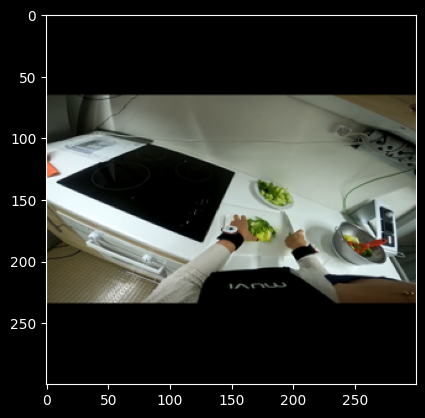

In [21]:
# show one random frame of the train_set with the detected hand

import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# select a random frame
frame_index = random.randint(0, test_frames.shape[0]-1)
image = test_frames[frame_index,:,:,:]
image_width = image.shape[1]
image_height = image.shape[0]

# display the frame
fig, ax = plt.subplots(1)
ax.imshow(image)

# display first hand in the frame if detected
if hands[frame_index][1] is not None:
    rect = patches.Rectangle((hands[frame_index][1][0]-30, hands[frame_index][1][1]-30), 50, 50, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# display center of the first hand in the frame if detected
if hands[frame_index][1] is not None:
    rect = patches.Rectangle((hands[frame_index][1][0]-5, hands[frame_index][1][1]-5), 10, 10, linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

# display second hand in the frame if detected
if hands[frame_index][2] is not None:
    rect = patches.Rectangle((hands[frame_index][2][0]-30, hands[frame_index][2][1]-30), 50, 50, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# display center of the second hand in the frame if detected
if hands[frame_index][2] is not None:
    rect = patches.Rectangle((hands[frame_index][2][0]-5, hands[frame_index][2][1]-5), 10, 10, linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

plt.show()